<a href="https://colab.research.google.com/github/vinson2233/LU_UC2024/blob/main/UC_Vinson_copy_18Dec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Package Installation

terratorch is still in active development, so we need to use a specific commit to ensure stability

In [ ]:
!pip install glymur
!pip install git+https://github.com/IBM/terratorch.git@30dfdf1
!pip install --upgrade huggingface_hub
!pip install git+https://github.com/IBM/granite-wxc.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 38.2 MB/s eta 0:00:00
  Cloning https://github.com/IBM/terratorch.git (to revision 30dfdf1) to /tmp/pip-req-build-9d93sn08
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/terratorch.git /tmp/pip-req-build-9d93sn08
  Running command git checkout -q 30dfdf1
  Resolved https://github.com/IBM/terratorch.git to commit 30dfdf1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could t

  Cloning https://github.com/IBM/granite-wxc.git to /tmp/pip-req-build-b82rfw7p
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/granite-wxc.git /tmp/pip-req-build-b82rfw7p
  Resolved https://github.com/IBM/granite-wxc.git to commit 679b96f6f31793bb78aca1d247bb04e58ecd3e28
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for granitewxc: filename=granitewxc-0.1.0-py3-none-any.whl size=29588 sha256=c0ae4f668ca2a1a3d3a24fda9fc031f82ba58e3fee571a747de4ab0649c04806
  Stored in directory: /tmp/pip-ephem-wheel-cache-dcni9e7d/wheels/12/8d/e8/add0e7dbc3c49f65eb1d6c29400ef6acbf37f1d8d000d98f77
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=eddb40310c2f7ed4006308597c65dbc40f7f8d667c0cf30015e98444d5a1d8a3
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97

2. Library imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import pandas as pd
import glymur
import torch
import terratorch
from terratorch.models import EncoderDecoderFactory
from terratorch.datasets import HLSBands
from google.colab import drive
import os
import random
from glob import glob
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import time
import sys
import scipy.ndimage
from skimage import io
from skimage.transform import resize as skimage_resize
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler
from torch.autograd import Variable
from torchvision.transforms import RandomCrop
import torch.nn.functional as F

from terratorch.models import EncoderDecoderFactory
from terratorch.datasets import HLSBands

from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm import tqdm
from terratorch import BACKBONE_REGISTRY

# 3. Data Extraction
Assume that the data already exist in Google Drive.  
The dataset can be downloaded through this link : https://www.magicbathy.eu/magicbathynet.html
The dataset need to be extracted to colab temporary runtime to increase the speed (reading the data from google drive increase latency)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

# Define paths
zip_path = "/content/drive/MyDrive/MagicBathyNet.zip"
extract_path = "/content/MagicBathyNet"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")

Extraction complete.


Set seed

In [ ]:
# Set a seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Dataset creation

In [ ]:
data_folder = "/content/MagicBathyNet/MagicBathyNet"

# --------------------------------------------
#          HELPER FUNCTIONS
# --------------------------------------------
def extract_location_id(df, path_col):
    df['location'] = df[path_col].str.split("/").str[-4]
    df['image_id'] = df[path_col].str.split("/").str[-1].str.split("_").str[1].str.split(".").str[0]
    df['id_loc'] = df['location'] + "-" + df['image_id']
    return df

def create_split(df_files, scenario):
    """
    scenario options:
    1. "train_pl-test_an":
        - Puck Lagoon: 90% train, 10% val
        - Agia Napa: 100% test
    2. "mixed_random":
        - Combine both locations, randomly split:
          80% train, 10% val, 10% test
    """
    # Use a dedicated random generator with the predefined SEED
    rng = np.random.default_rng(SEED)

    if scenario == "train_pl-test_an":
        df_pl = df_files.query("location == 'puck_lagoon'").copy()
        df_an = df_files.query("location == 'agia_napa'").copy()

        pl_splits = rng.choice(['train','val'], p=[0.9,0.1], size=len(df_pl))
        df_pl['split'] = pl_splits
        df_an['split'] = 'test'
        df_files = pd.concat([df_pl, df_an], ignore_index=True)

    elif scenario == "mixed_random":
        # 80% train, 10% val, 10% test
        rand_split = rng.choice(['train','val','test'], p=[0.8,0.1,0.1], size=len(df_files))
        df_files['split'] = rand_split

    elif scenario == "train_pl-test_pl":
        df_pl = df_files.query("location == 'puck_lagoon'").copy()
        rand_split = rng.choice(['train','val','test'], p=[0.8,0.1,0.1], size=len(df_pl))
        df_pl['split'] = rand_split
        df_files=df_pl.copy()

    else:
        print("Scenario not recognized, defaulting to random splits.")
        rand_split = rng.choice(['train','val','test'], p=[0.8,0.1,0.1], size=len(df_files))
        df_files['split'] = rand_split

    return df_files

def print_summary_statistics(df_files):
    total_count = len(df_files)
    locations_count = df_files['location'].value_counts()

    print("----- Overall Statistics -----")
    print(f"Total Labeled Images: {total_count}")
    for loc, cnt in locations_count.items():
        pct = (cnt / total_count) * 100
        print(f"{loc}: {cnt} images ({pct:.2f}%)")

    ct = pd.crosstab(df_files['location'], df_files['split'])
    print("\n----- Split by Location -----")
    print(ct)

    print("\n----- Split by Location (Percentages) -----")
    ct_percent = ct.apply(lambda x: (x / x.sum())*100, axis=1)
    print(ct_percent.round(2))

    split_counts = df_files['split'].value_counts()
    print("\n----- Overall Split Counts -----")
    for s, cnt in split_counts.items():
        pct = (cnt / total_count) * 100
        print(f"{s}: {cnt} images ({pct:.2f}%)")

Read the data, convert it into pandas dataframe

In [ ]:
list_depth = glob(data_folder + "/*/depth/s2/depth_*.tif")
list_img = glob(data_folder + "/*/img/s2/img_*.tif")

df_img = pd.DataFrame(list_img, columns=["image_path"])
df_img = extract_location_id(df_img,"image_path")

df_depth = pd.DataFrame(list_depth, columns=["depth_path"])
df_depth = extract_location_id(df_depth,"depth_path")

set_images = set(df_img['id_loc'].tolist())
set_depth = set(df_depth['id_loc'].tolist())
set_intersection = set_depth.intersection(set_images)

df_img = df_img[df_img['id_loc'].isin(set_intersection)]
df_depth = df_depth[df_depth['id_loc'].isin(set_intersection)]
df_files = df_img.merge(df_depth, on=['location','image_id','id_loc'])[['image_path','depth_path','location']]


Choose scenarios for which kind of dataset splits required



In [ ]:
# --------------------------------------------
#          CHOOSE SCENARIO
# --------------------------------------------
# Example scenarios:
scenario = "train_pl-test_pl"
# scenario = "train_pl-test_an"  # change as desired

df_files = create_split(df_files, scenario=scenario)
print_summary_statistics(df_files)

----- Overall Statistics -----
Total Labeled Images: 3314
puck_lagoon: 3314 images (100.00%)

----- Split by Location -----
split        test  train  val
location                     
puck_lagoon   342   2648  324

----- Split by Location (Percentages) -----
split         test  train   val
location                       
puck_lagoon  10.32   79.9  9.78

----- Overall Split Counts -----
train: 2648 images (79.90%)
test: 342 images (10.32%)
val: 324 images (9.78%)


Custom loss creation

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, output, depth, mask):
        mse_loss = nn.MSELoss(reduction='none')
        loss = mse_loss(output, depth)
        loss = (loss * mask.float()).sum()
        non_zero_elements = mask.sum()
        rmse_loss_val = torch.sqrt(loss / non_zero_elements)
        return rmse_loss_val

def metrics(pred, gts):
    non_zero_mask = (gts != 0) # exclude prediction if its non-water body
    rmse = np.sqrt(np.mean(((pred - gts) ** 2)[non_zero_mask]))
    mae = np.mean(np.abs((pred - gts)[non_zero_mask]))
    std_dev = np.std((pred - gts)[non_zero_mask])
    return rmse,mae,std_dev

Pixel resizing of the images.  
Play with the sample size for each epoch here.  
For most part we follow the augmentation procedure from the code provided by author of MagicBathyUnet.

In [ ]:
norm_param = {}
norm_param['agia_napa'] = np.load(data_folder + '/agia_napa/norm_param_s2_an.npy')
norm_param['puck_lagoon'] = np.load(data_folder + '/puck_lagoon/norm_param_s2_pl.npy')
norm_param_depth = {"agia_napa":-30.443,"puck_lagoon":-11}

WINDOW_SIZE = (18, 18)
CACHE = False

class dataset(torch.utils.data.Dataset):
    def __init__(self, df_data, cache=False, use_augmentation=False, resize_choice="original", n_value=2):
        super(dataset, self).__init__()
        self.cache = cache
        self.use_augmentation = use_augmentation
        self.resize_choice = resize_choice
        self.n_value = n_value
        self.data_files = df_data['image_path'].tolist()
        self.label_files = df_data['depth_path'].tolist()
        self.location = df_data['location'].tolist()
        self.data_cache_ = {}
        self.label_cache_ = {}

    def data_augmentation(self, arr, lbl):
        will_flip = random.random() < 0.5
        will_mirror = random.random() < 0.5
        if will_flip:
            arr = arr[:, ::-1, :]
            lbl = lbl[::-1, :]
        if will_mirror:
            arr = arr[:, :, ::-1]
            lbl = lbl[:, ::-1]
        return arr, lbl

    def __len__(self):
        return 2000

    def __getitem__(self, i):
        random_idx = random.randint(0, len(self.data_files) - 1)
        location = self.location[random_idx]

        if random_idx in self.data_cache_:
            data = self.data_cache_[random_idx]
        else:
            data_im = io.imread(self.data_files[random_idx])
            data_im = data_im.transpose((2,0,1)).astype('float32')
            data = (data_im - norm_param[location][0][:, np.newaxis, np.newaxis]) / (
                norm_param[location][1][:, np.newaxis, np.newaxis] - norm_param[location][0][:, np.newaxis, np.newaxis])
            if self.cache:
                self.data_cache_[random_idx] = data

        if random_idx in self.label_cache_:
            label = self.label_cache_[random_idx]
        else:
            label_im = io.imread(self.label_files[random_idx]).astype('float32')
            label = 1/norm_param_depth[location] * label_im
            if self.cache:
                self.label_cache_[random_idx] = label

        def get_random_pos(img, window_shape):
            w, h = window_shape
            W, H = img.shape[-2:]
            x1 = random.randint(0, W - w)
            x2 = x1 + w
            y1 = random.randint(0, H - h)
            y2 = y1 + h
            return x1, x2, y1, y2

        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2, y1:y2]
        label_p = label[x1:x2, y1:y2]

        if self.use_augmentation:
            data_p, label_p = self.data_augmentation(data_p, label_p)

        # Convert to tensor and resize if needed
        data_tensor = torch.from_numpy(data_p.copy())
        label_tensor = torch.from_numpy(label_p.copy())

        if self.resize_choice == "256x256":
            data_tensor = F.interpolate(data_tensor.unsqueeze(0), size=(256,256), mode='nearest').squeeze(0)
            label_tensor = F.interpolate(label_tensor.unsqueeze(0).unsqueeze(0), size=(256,256), mode='nearest').squeeze(0).squeeze(0)
        if self.resize_choice == "32x32":
            data_tensor = F.interpolate(data_tensor.unsqueeze(0), size=(32,32), mode='nearest').squeeze(0)
            label_tensor = F.interpolate(label_tensor.unsqueeze(0).unsqueeze(0), size=(32,32), mode='nearest').squeeze(0).squeeze(0)
        if self.resize_choice == "64x64":
            data_tensor = F.interpolate(data_tensor.unsqueeze(0), size=(64,64), mode='nearest').squeeze(0)
            label_tensor = F.interpolate(label_tensor.unsqueeze(0).unsqueeze(0), size=(64,64), mode='nearest').squeeze(0).squeeze(0)
        if self.resize_choice == "128x128":
            data_tensor = F.interpolate(data_tensor.unsqueeze(0), size=(128,128), mode='nearest').squeeze(0)
            label_tensor = F.interpolate(label_tensor.unsqueeze(0).unsqueeze(0), size=(128,128), mode='nearest').squeeze(0).squeeze(0)
        elif self.resize_choice == "n_times":
            new_size = (WINDOW_SIZE[0]*self.n_value, WINDOW_SIZE[1]*self.n_value)
            data_tensor = F.interpolate(data_tensor.unsqueeze(0), size=new_size, mode='nearest').squeeze(0)
            label_tensor = F.interpolate(label_tensor.unsqueeze(0).unsqueeze(0), size=new_size, mode='nearest').squeeze(0).squeeze(0)
        # original: no resizing
        # data_tensor = torch.stack([data_tensor, data_tensor], dim=0)
        return data_tensor, label_tensor, location


In [ ]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target, _ in loader:
            data, target = data.to(device), target.to(device)
            data_mask = (data != 0).float().mean(dim=1) # (B,H,W)
            target_mask = (target != 0).float()
            combined_mask = (target_mask * data_mask >= 0.5).float()
            if torch.sum(combined_mask) == 0:
                # if no valid pixels, skip this batch
                continue
            output = model(data.float())
            loss = criterion(output.output, target, combined_mask)
            total_loss += loss.item() * data.size(0)
    # If combined_mask=0 skip is frequent, consider tracking how many samples contributed
    # For simplicity, assume we processed all and didn't skip all samples
    return total_loss / len(loader.dataset)

# CHANGED: Compute metrics by location as previously done
def compute_metrics_by_location(model, loader, device, norm_param_depth):
    model.eval()
    preds_by_location = {}
    targets_by_location = {}
    correction_by_location = {}

    with torch.no_grad():
        for data, target, locations in loader:
            # data = data.repeat(1,2,1,1)
            data, target = data.to(device), target.to(device)
            output = model(data.float())
            preds = output.output.cpu().numpy()
            targets = target.cpu().numpy()

            for i, loc in enumerate(locations):
                factor = norm_param_depth[loc]
                pred_orig = preds[i]
                target_orig = targets[i]
                if loc not in preds_by_location:
                    preds_by_location[loc] = []
                    targets_by_location[loc] = []
                    correction_by_location[loc] = []
                preds_by_location[loc].extend(pred_orig.ravel())
                targets_by_location[loc].extend(target_orig.ravel())
                correction_by_location[loc].append(factor)

    results = {}
    for loc in preds_by_location:
        factor = correction_by_location[loc][0]
        p = np.array(preds_by_location[loc])
        t = np.array(targets_by_location[loc])
        rmse,mae,std_dev = metrics(p,t)
        rmse *= -factor
        mae *= -factor
        std_dev *= -factor
        results[loc] = (rmse, mae, std_dev)

    return results

def get_location_counts(df, locations):
    counts = {}
    for loc in locations:
        counts[loc] = len(df.query("location == @loc"))
    return counts

def format_metrics(split_name, loc_results, loc_counts):
    row_str = f"{split_name:<12}"
    for loc in locations:
        if loc in loc_results:
            rmse, mae, std_dev = loc_results[loc]
            cnt = loc_counts.get(loc, 0)
            row_str += f"{rmse:7.3f}{mae:7.3f}{std_dev:7.3f}{cnt:10d}    "
        else:
            cnt = loc_counts.get(loc, 0)
            row_str += f"{'N/A':>7}{'N/A':>7}{'N/A':>7}{cnt:10d}    "
    return row_str

Choosing data split scenarios

In [ ]:
# User choices
epochs = 25
pause_frequency = 50
  BATCH_SIZE = 4

resize_choice = "n_times"   # "original", "256x256", or "n_times"
use_augmentation = True

locations = ["agia_napa", "puck_lagoon"]
splits = ["train", "val", "test"]

for n_value in [1,2,4,6,8,10,12,14,16,18]: # Try different factor of upscaling. The based patch size is 18x18
  train_df = df_files.query("split=='train'")
  val_df = df_files.query("split=='val'")
  if len(val_df) == 0 and len(train_df) > 0:
      val_df = train_df.sample(frac=0.1, random_state=SEED)
      train_df = train_df.drop(val_df.index)

  train_dataset = dataset(train_df, cache=False, use_augmentation=use_augmentation, resize_choice=resize_choice, n_value=n_value)
  val_dataset = dataset(val_df, cache=False, use_augmentation=False, resize_choice=resize_choice, n_value=n_value)

  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

  model_factory = EncoderDecoderFactory()
  model = model_factory.build_model(task="regression",
          backbone="prithvi_eo_v1_100",
          decoder="FCNDecoder",
          backbone_bands=[
              HLSBands.BLUE,
              HLSBands.GREEN,
              HLSBands.RED,
          ],
          necks=[{"name": "SelectIndices", "indices": [-1]},
                {"name": "ReshapeTokensToImage"}],
          backbone_pretrained=True,
          backbone_num_frames=1,
          decoder_channels=128,
          head_dropout=0.2
      )

  model.freeze_encoder()

  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)

  criterion = CustomLoss()

  optimizer = optim.AdamW(
      model.parameters(),
      lr=0.0005,
      weight_decay=1e-4, # L2 regularization
  )

  train_losses = []
  val_losses = []

  # for e in range(start, end):
  for e in range(1, epochs + 1):
      model.train()
      running_loss = 0
      total_samples = 0
      with tqdm(train_loader, desc=f"Epoch {e}/{epochs}", unit="batch") as tbar:
          for data, target, _ in tbar:
              # data=data.repeat(1,2,1,1)
              data, target = data.to(device), target.to(device)

              # CHANGED: Removed the random crop logic entirely.
              # Now we assume `data` and `target` are already in the correct final size from the dataset __getitem__ logic.
              # If `resize_choice` is "256x256", "n_times", or "original", the dataset code should handle it.

              # Create combined mask
              target_mask = (target != 0).float()
              data_mask = (data != 0).float().mean(dim=1)
              combined_mask = (target_mask * data_mask >= 0.5).float()

              # If no valid pixels, skip this batch
              if torch.sum(combined_mask) == 0:
                  continue

              optimizer.zero_grad()
              output = model(data.float())
              loss = criterion(output.output, target, combined_mask)
              loss.backward()
              optimizer.step()

              batch_size = data.size(0)
              running_loss += loss.item() * batch_size
              total_samples += batch_size
              current_loss = running_loss / total_samples
              tbar.set_postfix(loss=current_loss)

  # Evaluate on test set
  test_df = df_files.query("split=='test'")
  results_s2 = {}

  if len(train_df) > 0:
      train_metrics = compute_metrics_by_location(model, train_loader, device, norm_param_depth)
      results_s2["train"] = train_metrics
  if len(val_df) > 0:
      val_metrics = compute_metrics_by_location(model, val_loader, device, norm_param_depth)
      results_s2["val"] = val_metrics
  if len(test_df) > 0:
      test_dataset = dataset(test_df, cache=False, use_augmentation=False, resize_choice=resize_choice, n_value=n_value)
      test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
      test_metrics = compute_metrics_by_location(model, test_loader, device, norm_param_depth)
      results_s2["test"] = test_metrics

  # Get counts
  train_counts = get_location_counts(train_df, locations) if len(train_df) > 0 else {}
  val_counts = get_location_counts(val_df, locations) if len(val_df) > 0 else {}
  test_counts = get_location_counts(test_df, locations) if len(test_df) > 0 else {}

  print("\nResults (S2) in meters:")

  header_line_1 = f"{'':12}{'Agia Napa':^31}{'Puck Lagoon':^31}"
  header_line_2 = f"{'':12}{'RMSE':>7}{'MAE':>7}{'Std':>7}{'Count':>10}    {'RMSE':>7}{'MAE':>7}{'Std':>7}{'Count':>10}"
  print(header_line_1)
  print(header_line_2)
  print("-"*(12+31+31))

  for sp in splits:
      row_label = f"{sp}_s2"
      if sp in results_s2:
          loc_results = results_s2[sp]
          if sp == "train":
              row_str = format_metrics(row_label, loc_results, train_counts)
          elif sp == "val":
              row_str = format_metrics(row_label, loc_results, val_counts)
          elif sp == "test":
              row_str = format_metrics(row_label, loc_results, test_counts)
      else:
          # No results for this split
          if sp == "train":
              row_str = format_metrics(row_label, {}, train_counts)
          elif sp == "val":
              row_str = format_metrics(row_label, {}, val_counts)
          elif sp == "test":
              row_str = format_metrics(row_label, {}, test_counts)

      print(row_str)
  print("n_value :",n_value)
  print("="*50)
  print("="*50)
  print("="*50)

# Save final model
# torch.save(model.state_dict(), 'model_final.pth')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/895 [00:00<?, ?B/s]

Prithvi_EO_V1_100M.pt:   0%|          | 0.00/454M [00:00<?, ?B/s]

Epoch 25/25: 100%|██████████| 500/500 [01:11<00:00,  6.99batch/s, loss=0.0669]



Results (S2) in meters:
                       Agia Napa                     Puck Lagoon          
               RMSE    MAE    Std     Count       RMSE    MAE    Std     Count
--------------------------------------------------------------------------
train_s2        N/A    N/A    N/A         0      1.158  0.487  1.155      2648    
val_s2          N/A    N/A    N/A         0      1.065  0.483  1.060       324    
test_s2         N/A    N/A    N/A         0      0.966  0.440  0.964       342    
n_value : 18


Prediction Example

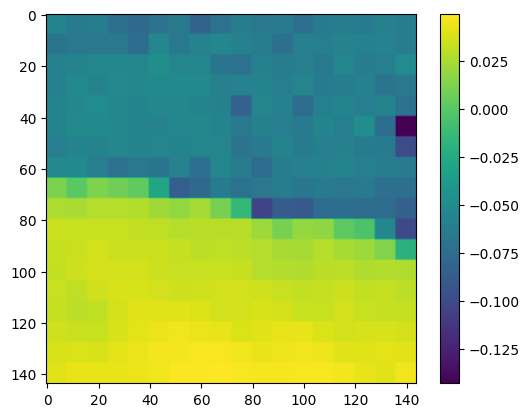

In [ ]:
target_ex = target[2].detach().cpu().numpy()
plt.imshow(target_ex)
plt.colorbar()

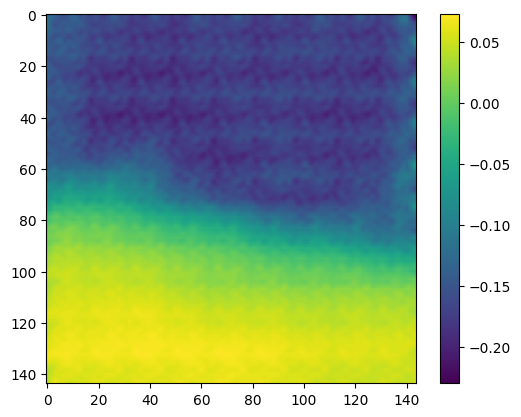

In [ ]:
target_ex = output.output[2].detach().cpu().numpy()
plt.imshow(target_ex)
plt.colorbar()